In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading and looking into the dataset
df = pd.read_csv('monthly-robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
print(df.tail())

Month
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, dtype: int64


In [3]:
# splitting the dataset - train and validation
split_point = len(df)-12
dataset, validation = df[0:split_point], df[split_point:]
print("Dataset: %d, Validation: %d" %(len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset: 106, Validation: 12


- Dataset -> Jan 1996 - Oct 1974
- Validation -> Nov 1974 - Oct 1975


- leaving validation out of scope!
- training and evaluate models only on dataset.csv

#### 1. Baseline model and performance

In [4]:
# Baseline model (Persistence model)
dataset = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

X = dataset.values
X = X.astype('float32')
train_size = int(len(X)*0.66)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    history.append(test[i])

# performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' %rmse)

RMSE: 55.147


#### 2. Data Analysis

In [5]:
# summary statistics
print(dataset.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


__Observations:__
- 106 observations in the dataset
- Standard deviation is relatively large at 112 robberies
- Percentiles and Standard deviation - very large i.e. there is a large spread in the data

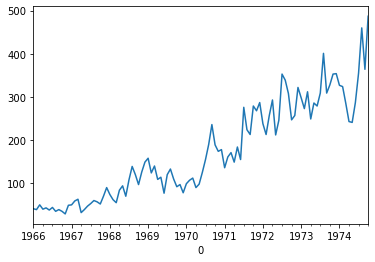

In [6]:
# line plot
dataset.plot()
plt.show()

__Observations:__
- Increasing trend of robberies over time
- Relatively large fluctuations from year to year!
- Fluctuations at later years are larger than those at earlier
- Trend suggests that the data is non-stationary!

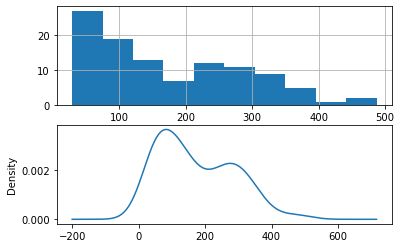

In [7]:
# density plot
plt.figure(1)
plt.subplot(211)
dataset.hist()
plt.subplot(212)
dataset.plot(kind='kde')
plt.show()

__Observations:__
- Distribution is not Gaussian!
- Left shifted and may be exponential!

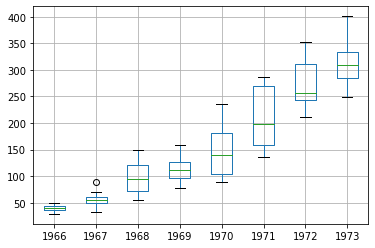

In [8]:
# box plots
groups = dataset['1966':'1973'].groupby(pd.Grouper(freq='Y'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

- the median for each year show a trend, which may not be linear
- the earlier years (maybe first 2 are quite different from the rest)

#### 3. ARIMA models!

__1. Manually Configured ARIMA__

In [9]:
# check stationarity

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i]-dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

X = dataset.values
stationary_check = difference(X)
stationary_check.index = dataset.index[1:]

result = adfuller(stationary_check)
print('ADF Statistics: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))

ADF Statistics: -3.980946
p-value: 0.001514
Critical values: 
	1%: -3.503
	5%: -2.893
	10%: -2.584


__Observations:__
- 1-lag differenced series!
- Test statistics value is less than critical value at 5% - we can reject null hypothesis with a significance level of less than 5% (i.e. a low probability that residual is statistical fluke)
- No unitroot, 1-lag differenced series is stationary!
- d = 1

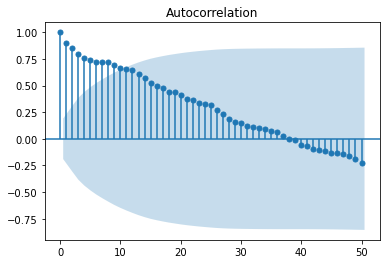

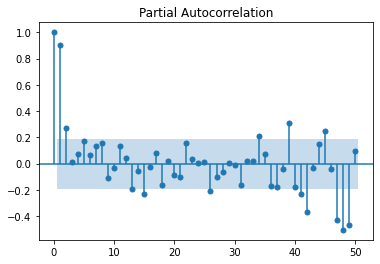

In [10]:
# plotting acf and pacf
plot_acf(dataset, lags=50)
plt.show()
plot_pacf(dataset, lags=50)
plt.show()

In [11]:
# first arima model
X = dataset.values
X = X.astype('float32')
train_size = int(len(X)*0.66)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[i])

rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' %rmse)

RMSE: 53.725


__2. Grid Search ARIMA hyperparameters__

In [12]:
# evaluate ARIMA model
def evaluate_arima(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# iterate ARIMA parameters
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' %(order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' %(best_cfg, best_score))
    
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3) # run from range(0,13)

evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=173.685
ARIMA(0, 0, 1) RMSE=109.433
ARIMA(0, 0, 2) RMSE=99.909
ARIMA(0, 1, 0) RMSE=55.099
ARIMA(0, 1, 1) RMSE=53.615
ARIMA(0, 1, 2) RMSE=52.568
ARIMA(0, 2, 0) RMSE=84.616
ARIMA(0, 2, 1) RMSE=55.683
ARIMA(0, 2, 2) RMSE=54.354
ARIMA(1, 0, 0) RMSE=56.710
ARIMA(1, 1, 0) RMSE=53.984
ARIMA(1, 1, 1) RMSE=52.229
ARIMA(1, 2, 0) RMSE=73.915
ARIMA(2, 0, 0) RMSE=55.438
ARIMA(2, 1, 0) RMSE=53.725
ARIMA(2, 1, 1) RMSE=53.646
ARIMA(2, 1, 2) RMSE=52.662
ARIMA(2, 2, 0) RMSE=65.140
ARIMA(2, 2, 1) RMSE=54.263
Best ARIMA(1, 1, 1) RMSE=52.229


- Best hyperparameters for the model are ARIMA(1,1,1)

__3. Review residual errors to evaluate any bias in the model__

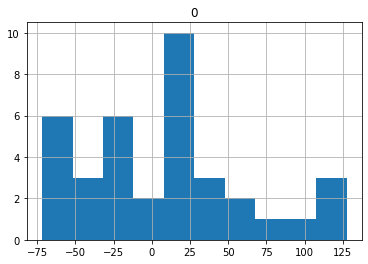

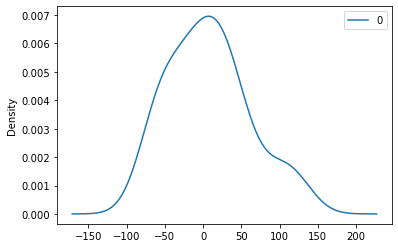

In [13]:
# with the best model which was grid-searched
X = dataset.values
X = X.astype('float32')
train_size = int(len(X)*0.66)
train, test = X[:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[i])

residuals = [test[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.hist()
plt.show()
residuals.plot(kind='kde')
plt.show()


__Observations:__
- the shape looks like Guassian with longer right tail!
- sign that predictions are biased!
- power-based transform of the raw data might be helpful??

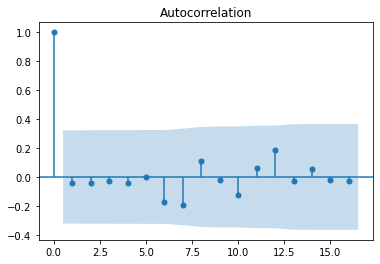

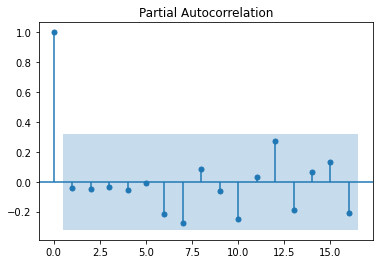

In [14]:
# acf and pacf of residuals
plot_acf(residuals)
plt.show()
plot_pacf(residuals)
plt.show()

__Observations:__
- model has captured little autocorrelation present in the series
- model has more oppurtunity to model the temporal structure in the data!

__4. Explore improvements!__

Lambda: 0.260060


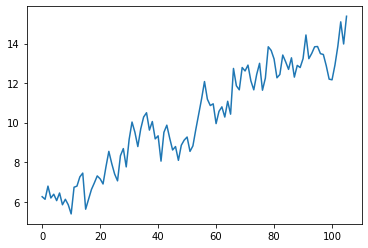

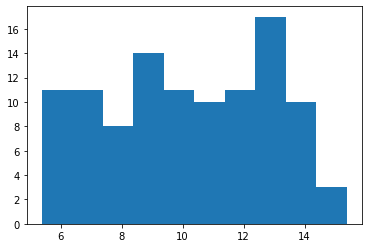

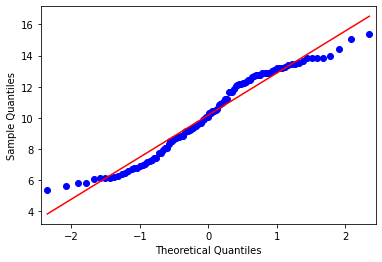

In [15]:
# Box-Cox transformation of original dataset
X = dataset.values
transformed, lmbda = boxcox(X)
print('Lambda: %f' %lmbda)
plt.plot(transformed)
plt.show()
plt.hist(transformed)
plt.show()
qqplot(transformed, line='r')
plt.show()

__Observations:__
- The fluctuations are removed after transforming the dataset!
- the histogram shows more uniform distribution!
- The Q-Q plot is fine, but still not a perfect fit for Guassian distribution!

`transformed = log(x), if lambda=0`

`x = exp(transformed)`


`transformed = (x^lambda - 1)/lambda, if lambda!=0`

`x = exp(log(lambda*transformed + 1)/lambda)`

In [16]:
# since we did transformation - it is important to perform 
#inverse transformation of predicted values to original scale

def boxcox_inverse(value, lmbda):
    if lmbda == 0:
        return math.exp(value)
    return math.exp(math.log(lmbda*value+1)/lmbda)

In [17]:
# ARIMA + transformation
X = dataset.values
X = X.astype('float32')
train_size = int(len(X)*0.66)
train, test = X[:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # transform
    transformed, lmbda = boxcox(history)
    if lmbda < -5:
        transformed, lmbda = history, 1
    # predict
    model = ARIMA(transformed, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformation
    yhat = boxcox_inverse(yhat, lmbda)
    predictions.append(yhat)
    history.append(test[i])

rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' %rmse)

RMSE: 50.134


- decreased from 52 to 50!

#### 4. Model Validation
- Finalize model
- make prediction
- validate model

In [18]:
# finalize and save the model!
X = dataset.values
X = X.astype('float32')
transformed, lmbda = boxcox(X)
model = ARIMA(transformed, order=(1,1,1))
model_fit = model.fit(disp=False)

model_fit.save('model.pkl')
np.save('model_lambda.npy', [lmbda])

In [19]:
def boxcox_inverse(value, lmbda):
    if lmbda == 0:
        return math.exp(value)
    return (math.exp(math.log(lmbda*value+1)/lmbda))

model_fit = ARIMAResults.load('model.pkl')
lmbda = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lmbda)

print("Predicted: %.3f" %yhat)

Predicted: 459.800


Expected: 452.000, Predicted: 459.800
Expected: 391.000, Predicted: 444.672
Expected: 500.000, Predicted: 410.588
Expected: 451.000, Predicted: 478.453
Expected: 375.000, Predicted: 454.627
Expected: 372.000, Predicted: 410.700
Expected: 302.000, Predicted: 409.261
Expected: 316.000, Predicted: 361.960
Expected: 398.000, Predicted: 369.005
Expected: 394.000, Predicted: 424.507
Expected: 431.000, Predicted: 423.622
Expected: 431.000, Predicted: 448.606
RMSE: 54.222


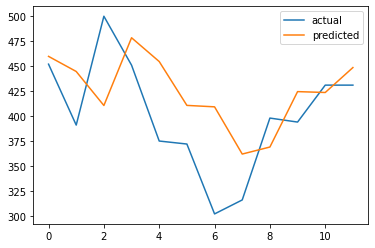

In [20]:
# evaluate the final model on validation set
def boxcox_inverse(value, lmbda):
    if lmbda == 0:
        return math.exp(value)
    return (math.exp(math.log(lmbda*value+1)/lmbda))

X = dataset.values.astype('float32')
validation = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')

history = [x for x in X]
predictions = list()

# rolling forecasts
for i in range(len(y)):
    transformed, lmbda = boxcox(history)
    if lmbda < -5:
        transformed, lmbda = history, 1
    model = ARIMA(transformed, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    yhat = boxcox_inverse(yhat, lmbda)
    predictions.append(yhat)
    history.append(y[i])
    print('Expected: %.3f, Predicted: %.3f' %(y[i], yhat))

rmse = np.sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' %rmse)

plt.plot(y, label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()

__Try:__
- __Grid serach with data transforms:__ Repeat the grid search in the ARIMA hyperparameters with the Box-Cox transform and see if a different and better set of parameters can be achieved


- __Inspect residuals:__ Investigate the residual forecast errors on the final model with Box-Cox transforms to see if there is a further bias and/or autocorrelation that can be addressed


- __Manually Handle Trend:__ Model the trend directly with a linear or nonlinear model and explicitly remove it from the series. This may result in better performance if the trend is nonlinear and can be modeled better than the linear case


- __Confidence Interval:__ Display the confidence intervals for the predictions on the validation dataset


- __Data Selection:__ Consider modeling the problem without the first two years of data and see if this has an impact on forecast skill


- __Lean Model Saving:__ Simplify model saving to only store the required coefficients rather than the entire ARIMAResults object


- __Statistical Significance Tests:__ Use a statistical test to check if the difference in results between different models is statistically significant. The Student’s t-test would be a good place to start